## Predict Ion Channel Opening - Modelling Part

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import torch
from torch import nn, optim
from torch.nn import functional as F

### 1. Importing pre-processed data

In [2]:
df, df_test = pd.read_csv('train_matrix.csv'), pd.read_csv('test_matrix.csv')
df.head()

time  signal  open_channels  denoised_signal  stable  block  block_mean  \
0  0.0001 -2.7600              0        -2.692369       1      0   -2.681517   
1  0.0002 -2.8557              0        -2.692137       1      0   -2.681517   
2  0.0003 -2.4074              0        -2.692303       1      0   -2.681517   
3  0.0004 -3.1404              0        -2.692241       1      0   -2.681517   
4  0.0005 -3.1525              0        -2.691679       1      0   -2.681517   

   block_std  min_block_signal  max_block_signal  residual     error  \
0   0.110437           -3.8506            3.5376  0.009407 -0.096989   
1   0.110437           -3.8506            3.5376  0.037129 -0.192689   
2   0.110437           -3.8506            3.5376  0.065337  0.255611   
3   0.110437           -3.8506            3.5376  0.227900 -0.477389   
4   0.110437           -3.8506            3.5376  0.239599 -0.489488   

   error_std  normalized_signal  outliers  is_weak_outliers  is_avg_outliers  \
0    0.32928          -2.778505 -0.574617                 0                0   
1    0.32928          -2.874205 -0.546895                 0                0   
2    0.32928          -2.425905 -0.518687                 0                0   
3    0.32928          -3.158905 -0.356124                 0                0   
4    0.32928          -3.171005 -0.344425                 0                0   

   is_strong_outliers  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

In [3]:
df_test.head()

time  signal  denoised_signal  stable  block  block_mean  block_std  \
0  500.0001 -2.6498        -2.688964       2      0   -1.098369   0.905024   
1  500.0002 -2.8494        -2.688599       2      0   -1.098369   0.905024   
2  500.0003 -2.8600        -2.688358       2      0   -1.098369   0.905024   
3  500.0004 -2.4350        -2.688329       2      0   -1.098369   0.905024   
4  500.0005 -2.6155        -2.688431       2      0   -1.098369   0.905024   

   min_block_signal  max_block_signal  residual     error  error_std  \
0           -3.6062            2.0018  0.001797 -0.042386   0.401972   
1           -3.6062            2.0018  0.058572 -0.242017   0.401972   
2           -3.6062            2.0018  0.063831 -0.252647   0.401972   
3           -3.6062            2.0018  0.029695  0.172322   0.401972   
4           -3.6062            2.0018  0.000067 -0.008208   0.401972   

   normalized_signal  outliers  is_weak_outliers  is_avg_outliers  \
0          -1.140755 -0.756022                 0                0   
1          -1.340386 -0.699246                 0                0   
2          -1.351016 -0.693988                 0                0   
3          -0.926047 -0.728123                 0                0   
4          -1.106577 -0.757751                 0                0   

   is_strong_outliers  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

In [4]:
for data in [df, df_test]:
    for block in np.unique(data.block):
        min_ = np.quantile(data.loc[data.block == block, 'signal'], 0.0001).astype(np.float32)
        max_ = np.quantile(data.loc[data.block == block, 'signal'], 0.9997).astype(np.float32)
        data.loc[data.block == block, 'min_block_signal'] = min_
        data.loc[data.block == block, 'max_block_signal'] = max_
del data
del block

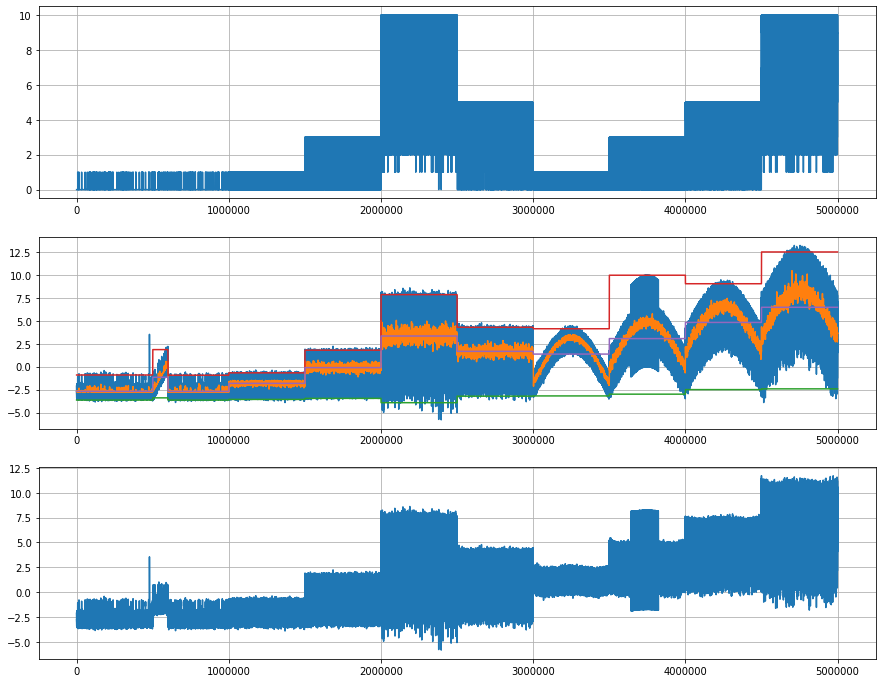

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
df.open_channels.plot(ax=ax[0])
ax[0].grid()
df.signal.plot(ax=ax[1])
df.denoised_signal.plot(ax=ax[1])
df.min_block_signal.plot(ax=ax[1])
df.max_block_signal.plot(ax=ax[1])
df.block_mean.plot(ax=ax[1])
ax[1].grid()
df.normalized_signal.plot(ax=ax[2])
ax[2].grid()
plt.show()

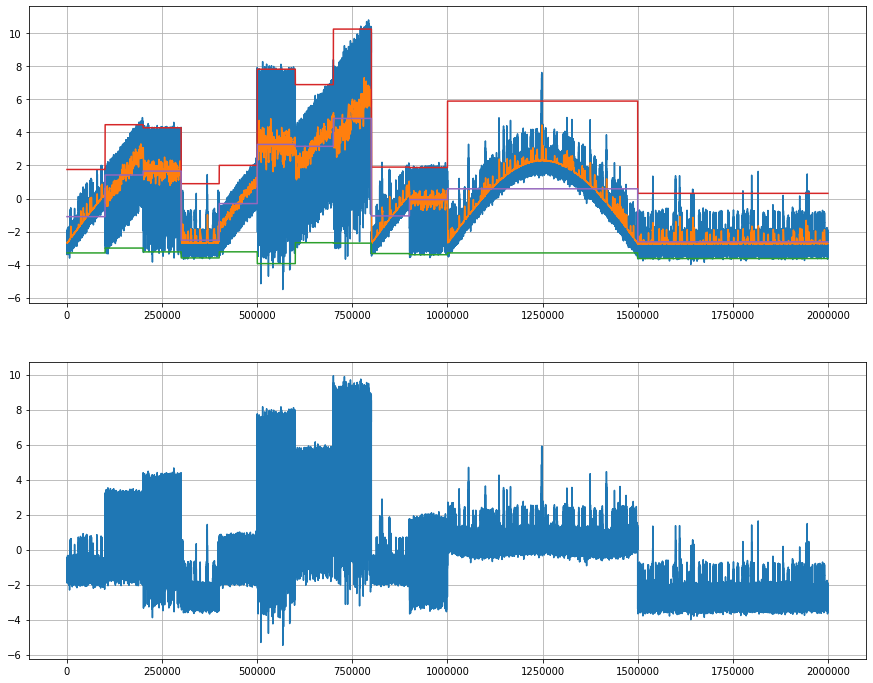

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
df_test.signal.plot(ax=ax[0])
df_test.denoised_signal.plot(ax=ax[0])
df_test.min_block_signal.plot(ax=ax[0])
df_test.max_block_signal.plot(ax=ax[0])
df_test.block_mean.plot(ax=ax[0])
ax[0].grid()
df_test.normalized_signal.plot(ax=ax[1])
ax[1].grid()
plt.show()

### 2.a Using all training data to fit. Predict testing data  

In [7]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def reduce():
    for data in [df, df_test]:
        print('Starting memory usage for matrix: {}'.format(np.sum(data.memory_usage())))
        for col in data.columns:
            col_mem_usage = data.memory_usage()[col]
            if col in ['stable', 'open_channels', 'block', 'is_weak_outliers', 'is_avg_outliers', 'is_strong_outliers']:
                data[col] = data[col].astype(np.int8)
            else:
                data[col] = data[col].astype(np.float32)
        print('Ending memory usage for matrix: {}'.format(np.sum(data.memory_usage())))
    del data

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

print('---------------')
reduce()
print('---------------')

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            df: 686.6 MiB
                       df_test: 259.4 MiB
                           _i7:  1.4 KiB
                         KFold:  1.0 KiB
                  GridSearchCV:  1.0 KiB
                  MinMaxScaler:  1.0 KiB
        RandomForestClassifier:  1.0 KiB
         RandomForestRegressor:  1.0 KiB
          KNeighborsClassifier:  1.0 KiB
                           SVC:  1.0 KiB
---------------
Starting memory usage for matrix: 720000128
Ending memory usage for matrix: 270000128
Starting memory usage for matrix: 272000128
Ending memory usage for matrix: 106000128
---------------
                            df: 257.5 MiB
                       df_test: 101.1 MiB
                           _i7:  1.4 KiB
                         KFold:  1.0 KiB
                  GridSearchCV:  1.0 KiB
                  MinMaxScaler:  1.0 KiB
        RandomForestClassifier:  1.0 KiB
         RandomForestRegressor:  1.0 KiB
          KNeighborsClassifier:  1.0 KiB
             

In [16]:
sample = pd.read_csv('submission.csv')
# sample['open_channels'] = y_hat_test
# sample.to_csv('my_submission2.csv', index = False, float_format='%.4f')
sample.head()

time  open_channels
0  500.0001              0
1  500.0002              0
2  500.0003              0
3  500.0004              0
4  500.0005              0

In [11]:
def get_data(train, test, sample):
    train_feat = train.drop(['open_channels', 'time', 'block'], axis=1)
    test_feat = test.drop(['time', 'block'], axis=1)
    X_train, y_train = train_feat.values, train['open_channels'].values
    X_test, y_test = test_feat.values, sample.open_channels

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    del train_feat
    del test_feat
    
    return X_train, y_train, X_test, y_test

def evaluate(prm, X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(**prm)
    model.fit(X_train, y_train)

    y_hat = model.predict(X_test).astype(np.int8)
    return model, y_hat

In [19]:
params = [{'n_estimators': 16,  'max_depth': 10, 'n_jobs': -1},
          {'n_estimators': 32,  'max_depth': 10, 'n_jobs': -1}, 
          {'n_estimators': 64,  'max_depth': 10, 'n_jobs': -1}, 
          {'n_estimators': 128, 'max_depth': 10, 'n_jobs': -1},
          {'n_estimators': 16,  'max_depth': 20, 'n_jobs': -1},
          {'n_estimators': 32,  'max_depth': 20, 'n_jobs': -1}, 
          {'n_estimators': 64,  'max_depth': 20, 'n_jobs': -1}, 
          {'n_estimators': 128, 'max_depth': 20, 'n_jobs': -1},
          {'n_estimators': 16,  'max_depth': 40, 'n_jobs': -1},
          {'n_estimators': 32,  'max_depth': 40, 'n_jobs': -1}, 
          {'n_estimators': 64,  'max_depth': 40, 'n_jobs': -1}, 
          {'n_estimators': 128, 'max_depth': 40, 'n_jobs': -1},
          {'n_estimators': 16,  'max_depth': 80, 'n_jobs': -1},
          {'n_estimators': 32,  'max_depth': 80, 'n_jobs': -1}, 
          {'n_estimators': 64,  'max_depth': 80, 'n_jobs': -1}, 
          {'n_estimators': 128, 'max_depth': 80, 'n_jobs': -1}]



models, res = [], []
for n, prm in enumerate(params):
    try:
        print('Starting iter {} out of {}'.format(n+1, len(params)))
        print('Parametes: {}'.format(prm))

        X_train, y_train, X_test, y_test = get_data(df, df_test, sample)
        model, y_hat = evaluate(prm, X_train, y_train, X_test, y_test)
        models.append(model)
        acc = np.round(accuracy_score(y_hat, y_test), 3)
        f1 = np.round(f1_score(y_hat, y_test, average='macro'), 3)
        res.append((f1, acc))


        print('Test metrics:\tA: {}\tF: {}'.format(acc, f1))
        print('----------------------------')

        del f1
        del acc
        del  X_train
        del y_train
        del X_test
        del y_test
        del prm

    except:
        print('Probable out of emory reached. Interrupting...')
        break

Starting iter 1 out of 16
Parametes: {'n_estimators': 16, 'max_depth': 10, 'n_jobs': -1}
Test metrics:	A: 0.8	F: 0.832
----------------------------
Starting iter 2 out of 16
Parametes: {'n_estimators': 32, 'max_depth': 10, 'n_jobs': -1}
Test metrics:	A: 0.762	F: 0.81
----------------------------
Starting iter 3 out of 16
Parametes: {'n_estimators': 64, 'max_depth': 10, 'n_jobs': -1}
Test metrics:	A: 0.766	F: 0.824
----------------------------
Starting iter 4 out of 16
Parametes: {'n_estimators': 128, 'max_depth': 10, 'n_jobs': -1}
Test metrics:	A: 0.798	F: 0.827
----------------------------
Starting iter 5 out of 16
Parametes: {'n_estimators': 16, 'max_depth': 20, 'n_jobs': -1}
Test metrics:	A: 0.799	F: 0.743
----------------------------
Starting iter 6 out of 16
Parametes: {'n_estimators': 32, 'max_depth': 20, 'n_jobs': -1}
Test metrics:	A: 0.8	F: 0.798
----------------------------
Starting iter 7 out of 16
Parametes: {'n_estimators': 64, 'max_depth': 20, 'n_jobs': -1}
Test metrics:	A

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 32building tree 2 of 32
building tree 3 of 32

building tree 4 of 32
building tree 5 of 32
building tree 6 of 32
building tree 7 of 32
building tree 8 of 32
building tree 9 of 32
building tree 10 of 32
building tree 11 of 32
building tree 12 of 32
building tree 13 of 32
building tree 14 of 32
building tree 15 of 32
building tree 16 of 32
building tree 17 of 32
building tree 18 of 32
building tree 19 of 32
building tree 20 of 32
building tree 21 of 32
building tree 22 of 32
building tree 23 of 32
building tree 24 of 32
building tree 25 of 32
building tree 26 of 32
building tree 27 of 32
building tree 28 of 32
building tree 29 of 32
building tree 30 of 32
building tree 31 of 32
building tree 32 of 32


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  3.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  32 out of  32 | elapsed:   22.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  32 out of  32 | elapsed:    8.4s finished


Train metrics:	A: 0.96	F: 0.926
Test metrics:	A: 0.82	F: 0.843


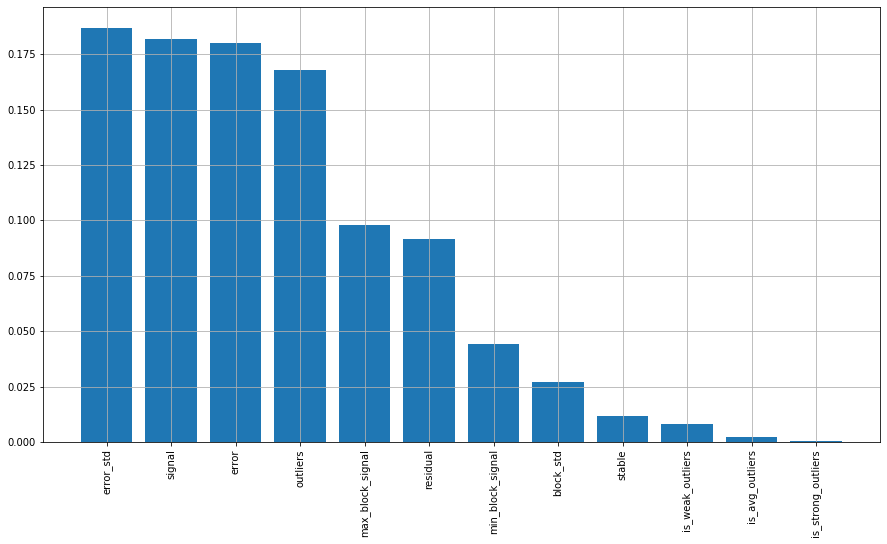

In [15]:
train_feat = df.drop(['open_channels', 'time', 'block'], axis=1)
test_feat = df_test.drop(['time', 'block'], axis=1)

X_train, y_train = train_feat.values, df['open_channels'].values
X_test, y_test = test_feat.values, sample.open_channels

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators = 32, n_jobs=-1, verbose=2, max_depth = 10)
model.fit(X_train, y_train)

y_hat_train, y_hat_test = model.predict(X_train).astype(np.int8), model.predict(X_test).astype(np.int8)

print('Train metrics:\tA: {}\tF: {}'.format(np.round(accuracy_score(y_hat_train, y_train), 3), 
                                            np.round(f1_score(y_hat_train, y_train, average='macro'), 3)))
print('Test metrics:\tA: {}\tF: {}'.format(np.round(accuracy_score(y_hat_test, y_test), 3), 
                                            np.round(f1_score(y_hat_test, y_test, average='macro'), 3)))

feat_imp = sorted(zip(model.feature_importances_, train_feat.columns), reverse = True)
name, value = [i[1] for i in feat_imp], [i[0] for i in feat_imp]

plt.figure(figsize=(15, 8))
plt.bar(name, value)
plt.xticks(name, rotation=90)
plt.grid()
plt.show()

### 2.c Visualize the results

In [18]:
sample['my_pred'] = y_hat_test
sample['error'] = abs(sample.open_channels - sample.my_pred)
sample.head()

time  open_channels  my_pred  error
0  500.0001              0        0      0
1  500.0002              0        0      0
2  500.0003              0        0      0
3  500.0004              0        0      0
4  500.0005              0        0      0

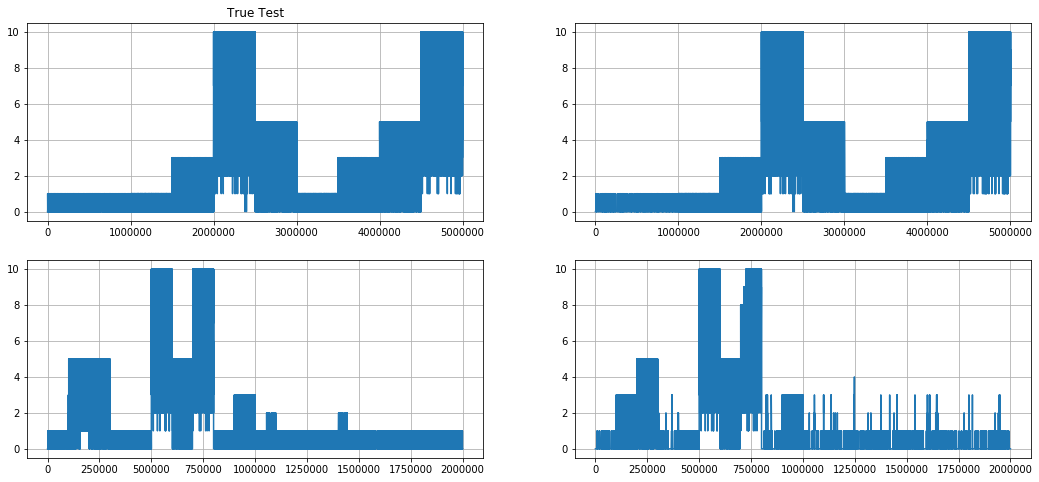

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(18, 8))
ax[0, 0].plot(y_hat_train)
ax[0, 0].set_title('Predicted Train')
ax[0, 0].grid()
ax[0, 1].plot(y_train)
ax[0, 0].set_title('True Train')
ax[0, 1].grid()
ax[1, 0].plot(y_hat_test)
ax[0, 0].set_title('Predicted Test')
ax[1, 0].grid()
ax[1, 1].plot(y_test)
ax[0, 0].set_title('True Test')
ax[1, 1].grid()
plt.show()

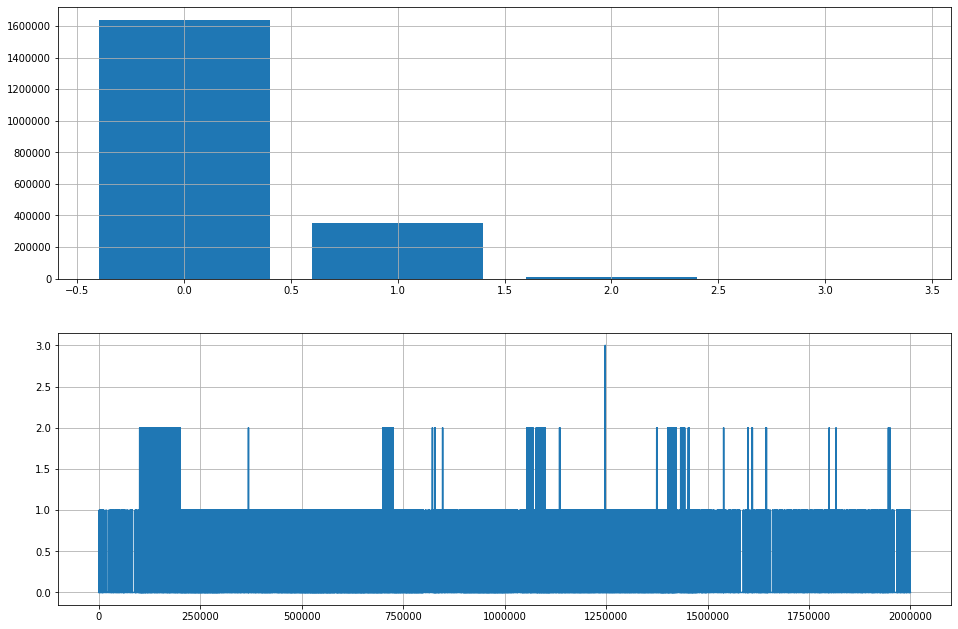

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(16, 11))

ax[0].bar(sample.error.value_counts().index, sample.error.value_counts().values)
ax[0].grid()
ax[1].plot(sample.error)
ax[1].grid()
plt.show()

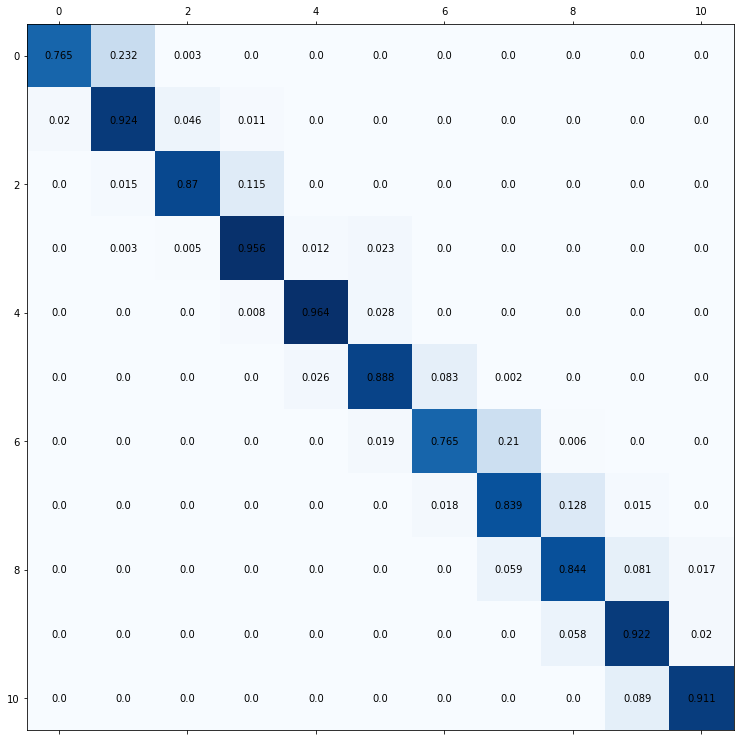

In [23]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(sample.my_pred, sample.open_channels)
cf_n = cf/np.sum(cf, axis=0)
fig, ax = plt.subplots(1, 1, figsize=(13, 13))
ax.matshow(cf_n.transpose(), cmap=cm.Blues)
for i in range(11):
    for j in range(11):
        ax.text(i, j, np.round(cf_n[i, j], 3), horizontalalignment='center', verticalalignment='center')
plt.show()

#### 2.c Save predicted values

In [22]:
my_sub = pd.read_csv('submission.csv')
my_sub.open_channels = y_hat_test
my_sub.to_csv('my_submission3.csv', index=False, float_format='%.4f')

### 3. LSTM + Feedforward

In [3]:
mat = np.zeros((df.shape[0], 12))
for i in range(10):
    mat[:, i] = df.shift(i).signal
mat[:, 10] = df.signal_mean
mat[:, 11] = df.stable
df_mat = pd.DataFrame(mat[9:, :], columns=[str(i) for i in range(10)]+['mean', 'stable'])
df_mat.head()

0       1       2       3       4       5       6       7       8  \
0 -2.7586 -2.6682 -2.5935 -2.6993 -2.6418 -3.1525 -3.1404 -2.4074 -2.8557   
1 -3.1136 -2.7586 -2.6682 -2.5935 -2.6993 -2.6418 -3.1525 -3.1404 -2.4074   
2 -2.6221 -3.1136 -2.7586 -2.6682 -2.5935 -2.6993 -2.6418 -3.1525 -3.1404   
3 -2.7316 -2.6221 -3.1136 -2.7586 -2.6682 -2.5935 -2.6993 -2.6418 -3.1525   
4 -2.9028 -2.7316 -2.6221 -3.1136 -2.7586 -2.6682 -2.5935 -2.6993 -2.6418   

        9      mean  stable  
0 -2.7600 -2.692259     1.0  
1 -2.8557 -2.692202     1.0  
2 -2.4074 -2.692553     1.0  
3 -3.1404 -2.692314     1.0  
4 -3.1525 -2.692246     1.0

In [5]:
class NN(nn.Module):
    
    def __init__(self):
        super(NN, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=4, num_layers=2, batch_first=True)
        
        self.l1a = nn.Linear(4, 6)
        self.l1b = nn.Linear(2, 5)
        
        self.l2 = nn.Linear(11, 30)
        self.l3 = nn.Linear(30, 20)
        self.l4 = nn.Linear(20, 11)
        
    def forward(self, x1, x2):
        # Signal
        x1, _ = self.rnn(x1)
        x1  = F.relu(self.l1a(x1[:, -1, :]))
        # Add_info
        x2  = F.relu(self.l1b(x2))
        x = torch.cat([x1, x2], dim=1)
        # Feed-Forward
        x  = F.relu(self.l2(x))
        x  = F.relu(self.l3(x))
        out  = self.l4(x)
        return out

In [6]:
net = NN()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

device = torch.device('cuda')
net = net.to(device)
if type(X_train1) != torch.Tensor:
    X_train1, X_train2 = torch.tensor(X_train1).to(device), torch.tensor(X_train2).to(device)
    X_test1, X_test2 = torch.tensor(X_test1).to(device), torch.tensor(X_test2).to(device)
    y_train, y_test = torch.tensor(y_train).to(device), torch.tensor(y_test).to(device)

In [7]:
from tqdm import tqdm
import time

batch_size = 2000
epochs = 100

loss_list = []
for ep in range(epochs):
    ll = []
    net.train()
    for batch in tqdm(range(X_train.shape[0]//batch_size)):
        x1 = X_train1[batch*batch_size:(batch+1)*batch_size, :].float()
        x2 = X_train2[batch*batch_size:(batch+1)*batch_size, :].float()
        label = y_train[batch*batch_size:(batch+1)*batch_size].float()
        out = net(x1, x2).view(-1, 11)        
        loss = loss_fn(out.float(),label.long())
        ll.append(loss.data.item())
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        net.eval()
        x1, x2 = X_test1.float(), X_test2.float()
        label = y_test
        out = net(x1, x2).view(-1, 11)
        loss = loss_fn(out.float(),label.long())
        
    y_hat = np.argmax(out.detach().cpu().numpy(), axis=1)
    y_true = label.cpu().numpy()
    time.sleep(2)
    print('Epoch: {}\ttrain_loss: {}\tval_loss: {}\tf1: {}'.format(ep, 
                                                                   np.round(np.mean(ll), 4), 
                                                                   np.round(loss.cpu().numpy(), 4), 
                                                                   np.round(f1_score(y_hat, y_true, average='macro'), 3)))
    time.sleep(2)
    

100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:49<00:00, 34.08it/s]


Epoch: 0	train_loss: 2.1499	val_loss: 2.0165998935699463	f1: 0.036


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.40it/s]


Epoch: 1	train_loss: 1.7873	val_loss: 1.587399959564209	f1: 0.137


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.51it/s]


Epoch: 2	train_loss: 1.5928	val_loss: 1.7285000085830688	f1: 0.138


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:49<00:00, 34.14it/s]


Epoch: 3	train_loss: 1.5671	val_loss: 1.5325000286102295	f1: 0.153


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.46it/s]


Epoch: 4	train_loss: 1.4862	val_loss: 1.4744999408721924	f1: 0.168


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.31it/s]


Epoch: 5	train_loss: 1.4229	val_loss: 1.405900001525879	f1: 0.209


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:49<00:00, 34.06it/s]


Epoch: 6	train_loss: 1.3888	val_loss: 1.3634999990463257	f1: 0.214


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.22it/s]


Epoch: 7	train_loss: 1.3629	val_loss: 1.3214000463485718	f1: 0.245


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.53it/s]


Epoch: 8	train_loss: 1.3448	val_loss: 1.308500051498413	f1: 0.251


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.50it/s]


Epoch: 9	train_loss: 1.3138	val_loss: 1.2930999994277954	f1: 0.275


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.52it/s]


Epoch: 10	train_loss: 1.2631	val_loss: 1.2122000455856323	f1: 0.356


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.51it/s]


Epoch: 11	train_loss: 1.1919	val_loss: 1.1735999584197998	f1: 0.338


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.56it/s]


Epoch: 12	train_loss: 1.126	val_loss: 1.1404999494552612	f1: 0.311


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.77it/s]


Epoch: 13	train_loss: 1.0909	val_loss: 1.1318999528884888	f1: 0.335


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.35it/s]


Epoch: 14	train_loss: 1.0554	val_loss: 1.0153000354766846	f1: 0.393


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:47<00:00, 34.91it/s]


Epoch: 15	train_loss: 1.0432	val_loss: 1.0033999681472778	f1: 0.426


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.86it/s]


Epoch: 16	train_loss: 1.0369	val_loss: 0.9692999720573425	f1: 0.428


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.61it/s]


Epoch: 17	train_loss: 1.0461	val_loss: 0.9993000030517578	f1: 0.456


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.87it/s]


Epoch: 18	train_loss: 1.0554	val_loss: 1.0020999908447266	f1: 0.478


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:47<00:00, 35.18it/s]


Epoch: 19	train_loss: 1.0213	val_loss: 1.0492000579833984	f1: 0.393


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:50<00:00, 33.20it/s]


Epoch: 20	train_loss: 0.9999	val_loss: 0.9348000288009644	f1: 0.434


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:51<00:00, 32.60it/s]


Epoch: 21	train_loss: 0.9788	val_loss: 0.9553999900817871	f1: 0.483


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:49<00:00, 33.99it/s]


Epoch: 22	train_loss: 0.9341	val_loss: 0.9287999868392944	f1: 0.506


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:49<00:00, 34.11it/s]


Epoch: 23	train_loss: 0.9006	val_loss: 0.8669999837875366	f1: 0.538


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.65it/s]


Epoch: 24	train_loss: 0.9167	val_loss: 0.91839998960495	f1: 0.481


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.33it/s]


Epoch: 25	train_loss: 0.9371	val_loss: 1.0463999509811401	f1: 0.466


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.81it/s]


Epoch: 26	train_loss: 0.9692	val_loss: 0.8977000117301941	f1: 0.503


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.54it/s]


Epoch: 27	train_loss: 0.9892	val_loss: 1.0678000450134277	f1: 0.441


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:49<00:00, 34.08it/s]


Epoch: 28	train_loss: 0.9807	val_loss: 0.9682999849319458	f1: 0.511


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:49<00:00, 33.70it/s]


Epoch: 29	train_loss: 0.9281	val_loss: 0.8679999709129333	f1: 0.543


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:51<00:00, 32.63it/s]


Epoch: 30	train_loss: 0.9041	val_loss: 0.8978999853134155	f1: 0.57


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [01:17<00:00, 21.49it/s]


Epoch: 31	train_loss: 0.8734	val_loss: 0.8654000163078308	f1: 0.546


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [01:19<00:00, 21.09it/s]


Epoch: 32	train_loss: 0.8508	val_loss: 0.8823000192642212	f1: 0.54


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:53<00:00, 31.42it/s]


Epoch: 33	train_loss: 0.8606	val_loss: 0.8259000182151794	f1: 0.562


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.29it/s]


Epoch: 34	train_loss: 0.8507	val_loss: 0.8416000008583069	f1: 0.556


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:50<00:00, 33.38it/s]


Epoch: 35	train_loss: 0.8808	val_loss: 0.8914999961853027	f1: 0.522


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.74it/s]


Epoch: 36	train_loss: 0.9258	val_loss: 0.9692999720573425	f1: 0.51


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:47<00:00, 35.35it/s]


Epoch: 37	train_loss: 0.9397	val_loss: 0.8432000279426575	f1: 0.613


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:47<00:00, 35.10it/s]


Epoch: 38	train_loss: 0.9393	val_loss: 0.9800000190734863	f1: 0.46


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:47<00:00, 35.42it/s]


Epoch: 39	train_loss: 0.9193	val_loss: 0.892300009727478	f1: 0.544


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:47<00:00, 35.58it/s]


Epoch: 40	train_loss: 0.9257	val_loss: 0.885200023651123	f1: 0.602


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:47<00:00, 35.52it/s]


Epoch: 41	train_loss: 0.9649	val_loss: 0.8752999901771545	f1: 0.597


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:46<00:00, 35.80it/s]


Epoch: 42	train_loss: 0.9835	val_loss: 0.9941999912261963	f1: 0.519


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:47<00:00, 35.59it/s]


Epoch: 43	train_loss: 0.9999	val_loss: 0.96670001745224	f1: 0.506


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:47<00:00, 35.20it/s]


Epoch: 44	train_loss: 1.019	val_loss: 0.9641000032424927	f1: 0.529


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:55<00:00, 30.43it/s]


Epoch: 45	train_loss: 0.987	val_loss: 0.9544000029563904	f1: 0.517


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [01:09<00:00, 24.23it/s]


Epoch: 46	train_loss: 0.994	val_loss: 1.1375000476837158	f1: 0.395


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [01:00<00:00, 27.67it/s]


Epoch: 47	train_loss: 0.9691	val_loss: 1.0430999994277954	f1: 0.499


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:50<00:00, 33.16it/s]


Epoch: 48	train_loss: 0.944	val_loss: 0.9424999952316284	f1: 0.484


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:50<00:00, 33.40it/s]


Epoch: 49	train_loss: 0.9057	val_loss: 0.9168000221252441	f1: 0.545


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:49<00:00, 33.70it/s]


Epoch: 50	train_loss: 0.8871	val_loss: 0.9294000267982483	f1: 0.539


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:51<00:00, 32.75it/s]


Epoch: 51	train_loss: 0.8651	val_loss: 0.8715000152587891	f1: 0.583


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:54<00:00, 30.56it/s]


Epoch: 52	train_loss: 0.8413	val_loss: 0.847100019454956	f1: 0.583


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:49<00:00, 33.60it/s]


Epoch: 53	train_loss: 0.8214	val_loss: 0.8133000135421753	f1: 0.629


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:50<00:00, 33.07it/s]


Epoch: 54	train_loss: 0.8149	val_loss: 0.8003000020980835	f1: 0.627


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:50<00:00, 33.13it/s]


Epoch: 55	train_loss: 0.8191	val_loss: 0.8118000030517578	f1: 0.631


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:50<00:00, 33.35it/s]


Epoch: 56	train_loss: 0.8268	val_loss: 0.814300000667572	f1: 0.596


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:49<00:00, 33.53it/s]


Epoch: 57	train_loss: 0.8187	val_loss: 0.8342000246047974	f1: 0.585


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:59<00:00, 28.36it/s]


Epoch: 58	train_loss: 0.8211	val_loss: 0.8402000069618225	f1: 0.597


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:50<00:00, 33.35it/s]


Epoch: 59	train_loss: 0.8104	val_loss: 0.8281000256538391	f1: 0.575


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:54<00:00, 30.99it/s]


Epoch: 60	train_loss: 0.8142	val_loss: 0.843999981880188	f1: 0.557


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:49<00:00, 33.77it/s]


Epoch: 61	train_loss: 0.8319	val_loss: 0.8787000179290771	f1: 0.538


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.36it/s]


Epoch: 62	train_loss: 0.8389	val_loss: 0.824400007724762	f1: 0.588


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:48<00:00, 34.51it/s]


Epoch: 63	train_loss: 0.8328	val_loss: 0.8367000222206116	f1: 0.583


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:49<00:00, 34.06it/s]


Epoch: 64	train_loss: 0.8363	val_loss: 0.8651999831199646	f1: 0.551


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:50<00:00, 32.86it/s]


Epoch: 65	train_loss: 0.8433	val_loss: 0.8526999950408936	f1: 0.555


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:53<00:00, 31.50it/s]


Epoch: 66	train_loss: 0.8434	val_loss: 0.8209999799728394	f1: 0.605


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:50<00:00, 33.12it/s]


Epoch: 67	train_loss: 0.8407	val_loss: 0.8956000208854675	f1: 0.523


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:51<00:00, 32.38it/s]


Epoch: 68	train_loss: 0.8467	val_loss: 0.9007999897003174	f1: 0.565


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:50<00:00, 32.88it/s]


Epoch: 69	train_loss: 0.8569	val_loss: 0.8130999803543091	f1: 0.622


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:58<00:00, 28.76it/s]


Epoch: 70	train_loss: 0.862	val_loss: 0.8641999959945679	f1: 0.609


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [01:01<00:00, 27.41it/s]


Epoch: 71	train_loss: 0.841	val_loss: 0.8443999886512756	f1: 0.607


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:56<00:00, 29.43it/s]


Epoch: 72	train_loss: 0.846	val_loss: 0.8395000100135803	f1: 0.613


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [01:01<00:00, 27.40it/s]


Epoch: 73	train_loss: 0.8634	val_loss: 0.8762000203132629	f1: 0.612


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:57<00:00, 28.96it/s]


Epoch: 74	train_loss: 0.8717	val_loss: 0.822700023651123	f1: 0.609


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:51<00:00, 32.30it/s]


Epoch: 75	train_loss: 0.8485	val_loss: 0.8216999769210815	f1: 0.605


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:54<00:00, 30.92it/s]


Epoch: 76	train_loss: 0.8625	val_loss: 0.8798999786376953	f1: 0.614


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:50<00:00, 33.22it/s]


Epoch: 77	train_loss: 0.8646	val_loss: 0.8784000277519226	f1: 0.612


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:50<00:00, 33.26it/s]


Epoch: 78	train_loss: 0.8772	val_loss: 0.8694999814033508	f1: 0.602


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:50<00:00, 32.87it/s]


Epoch: 79	train_loss: 0.9008	val_loss: 0.8616999983787537	f1: 0.578


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:53<00:00, 31.32it/s]


Epoch: 80	train_loss: 0.8734	val_loss: 0.8557000160217285	f1: 0.612


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:52<00:00, 31.79it/s]


Epoch: 81	train_loss: 0.8606	val_loss: 0.875	f1: 0.559


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:51<00:00, 32.78it/s]


Epoch: 82	train_loss: 0.86	val_loss: 0.858299970626831	f1: 0.636


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:52<00:00, 31.68it/s]


Epoch: 83	train_loss: 0.895	val_loss: 0.9574999809265137	f1: 0.526


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:52<00:00, 31.60it/s]


Epoch: 84	train_loss: 0.9195	val_loss: 0.8871999979019165	f1: 0.586


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:51<00:00, 32.36it/s]


Epoch: 85	train_loss: 0.9235	val_loss: 0.9531999826431274	f1: 0.488


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:52<00:00, 31.83it/s]


Epoch: 86	train_loss: 0.9072	val_loss: 0.9083999991416931	f1: 0.499


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:50<00:00, 32.86it/s]


Epoch: 87	train_loss: 0.8981	val_loss: 0.8725000023841858	f1: 0.526


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:51<00:00, 32.65it/s]


Epoch: 88	train_loss: 0.8714	val_loss: 0.8285999894142151	f1: 0.629


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:51<00:00, 32.40it/s]


Epoch: 89	train_loss: 0.8306	val_loss: 0.8306999802589417	f1: 0.608


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:51<00:00, 32.49it/s]


Epoch: 90	train_loss: 0.8246	val_loss: 0.8216999769210815	f1: 0.598


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:51<00:00, 32.63it/s]


Epoch: 91	train_loss: 0.8419	val_loss: 0.8754000067710876	f1: 0.563


100%|██████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:51<00:00, 32.64it/s]


Epoch: 92	train_loss: 0.8534	val_loss: 0.8790000081062317	f1: 0.538


 51%|████████████████████████████████████████▏                                      | 852/1674 [00:27<00:24, 33.49it/s]

KeyboardInterrupt: 

In [172]:
import time

def features(df):
    start_time = time.time()
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 25_000
    df['batch_index'] = df.index  - (df.batch * 25_000)
    df['batch_slices'] = df['batch_index']  // 2500
    df['batch_slices2'] = df.apply(lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)
    
    print('Step 1: {}'.format(time.time()-start_time))
    cnt_time = time.time()
    
    for c in ['batch','batch_slices2']:
        d = {}
        d['mean'+c] = df.groupby([c])['signal'].mean()
        d['median'+c] = df.groupby([c])['signal'].median()
        d['max'+c] = df.groupby([c])['signal'].max()
        d['min'+c] = df.groupby([c])['signal'].min()
        d['std'+c] = df.groupby([c])['signal'].std()
        d['mean_abs_chg'+c] = df.groupby([c])['signal'].apply(lambda x: np.mean(np.abs(np.diff(x))))
        d['abs_max'+c] = df.groupby([c])['signal'].apply(lambda x: np.max(np.abs(x)))
        d['abs_min'+c] = df.groupby([c])['signal'].apply(lambda x: np.min(np.abs(x)))
        d['range'+c] = d['max'+c] - d['min'+c]
        d['maxtomin'+c] = d['max'+c] / d['min'+c]
        d['abs_avg'+c] = (d['abs_min'+c] + d['abs_max'+c]) / 2
        for v in d:
            df[v] = df[c].map(d[v].to_dict())
        
        print('Step 2.{}: {}'.format(c, time.time()-cnt_time))
        cnt_time = time.time()
        
            
    
    #add shifts
    df['signal_shift_+1'] = [0,] + list(df['signal'].values[:-1])
    df['signal_shift_-1'] = list(df['signal'].values[1:]) + [0]
    
    print('Step 3: {}'.format(time.time()-cnt_time))
    cnt_time = time.time()
    
    for i in df[df['batch_index']==0].index:
        df['signal_shift_+1'][i] = np.nan
    for i in df[df['batch_index']==49999].index:
        df['signal_shift_-1'][i] = np.nan
    
    print('Step 4: {}'.format(time.time()-cnt_time))
    cnt_time = time.time()
    for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]:
        df[c+'_msignal'] = df[c] - df['signal']
        
    print('Total time: {}'.format(time.time()-start_time))
    return df


train = features(df)
print('train_complete')
test = features(df_test)

col = [c for c in train.columns if c not in ['time', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]
x1, x2, y1, y2 = model_selection.train_test_split(train[col], train['open_channels'], test_size=0.3, random_state=7)
target = train['open_channels']
train = train[col]

Step 1: 280.07590103149414
Step 2.batch: 24.730133771896362
Step 2.batch_slices2: 18.218770742416382
Step 3: 3.7752327919006348


C:\Users\fgrim\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Step 4: 4.886585712432861
Total time: 334.0162003040314
train_complete
Step 1: 109.4461760520935
Step 2.batch: 5.077563047409058
Step 2.batch_slices2: 6.743426084518433
Step 3: 1.4984378814697266
Step 4: 3.2313930988311768
Total time: 127.27661323547363


NameError: name 'model_selection' is not defined